In [1]:
import pandas as pd 
import sys 

sys.path.append('../../')
import helpers.data_helpers as data_helpers
import datetime
import pytz
import numpy as np 
import matplotlib.pyplot as plt
import backtesting 
from backtesting import Backtest, Strategy 

In [2]:
"""
The first thing we need to do to replicate this strategy is create the volatility model
We need to be concious that this dataframe the index is the open time for the minute
"""
df_btc = data_helpers.pickle_to_df('../../data/BTCUSDT_futures.pkl')

#make 90 million dollar bars 
db_90mill = data_helpers.dollar_bar_func(df_btc, 90_000_000)



In [22]:
#now we look at the duration 
db_90mill['duration'] = db_90mill['Close Time'] - db_90mill['Open Time']
db_90mill['duration minutes'] = db_90mill['duration'].dt.total_seconds() / 60

#only looking at 2022 onward
db_slice = db_90mill[db_90mill['Open Time'] > '2022-01-01'].copy()


In [23]:
#Now that we have dollar bars. we use a 50 period ema and 200 period sma to predict volatility
ema_window = 50
sma_window = 200

db_slice.loc[:, 'ema'] = db_slice['duration minutes'].ewm(span=ema_window, adjust=False).mean()
db_slice.loc[:, 'sma'] = db_slice['duration minutes'].rolling(window=sma_window).mean()

db_slice = db_slice.dropna()
db_slice

,Open,High,Low,Close,Volume,Open Time,Close Time,duration,duration minutes,ema,sma
74135,47013.23,47033.11,46921.86,46939.60,1959.971,2022-01-03 08:22:00+00:00,2022-01-03 08:52:59.999000+00:00,0 days 00:30:59.999000,30.999983,19.578040,17.054983
74136,46939.61,47100.00,46931.66,46985.28,1851.315,2022-01-03 08:53:00+00:00,2022-01-03 09:13:59.999000+00:00,0 days 00:20:59.999000,20.999983,19.633802,17.104983
74137,46985.29,46996.93,46800.00,46813.60,1942.552,2022-01-03 09:14:00+00:00,2022-01-03 09:19:59.999000+00:00,0 days 00:05:59.999000,5.999983,19.099143,17.019983
74138,46814.75,46892.35,46777.00,46846.80,2313.778,2022-01-03 09:20:00+00:00,2022-01-03 09:33:59.999000+00:00,0 days 00:13:59.999000,13.999983,18.899176,17.044983
74139,46846.80,46918.76,46809.91,46899.16,1650.325,2022-01-03 09:34:00+00:00,2022-01-03 09:48:59.999000+00:00,0 days 00:14:59.999000,14.999983,18.746266,17.049983
...,...,...,...,...,...,...,...,...,...,...,...
155808,40830.10,40861.40,40650.00,40704.00,2470.264,2023-12-11 20:03:00+00:00,2023-12-11 20:07:59.999000+00:00,0 days 00:04:59.999000,4.999983,3.749432,5.944983
155809,40704.00,40710.10,40571.00,40625.40,2460.307,2023-12-11 20:08:00+00:00,2023-12-11 20:10:59.999000+00:00,0 days 00:02:59.999000,2.999983,3.720042,5.839983
155810,40625.50,40749.50,40603.50,40614.40,2704.050,2023-12-11 20:11:00+00:00,2023-12-11 20:17:59.999000+00:00,0 days 00:06:59.999000,6.999983,3.848667,5.799983
155811,40614.50,40780.00,40582.30,40637.40,2368.103,2023-12-11 20:18:00+00:00,2023-12-11 20:24:59.999000+00:00,0 days 00:06:59.999000,6.999983,3.972248,5.809983


In [24]:
#When EMA > SMA then we are in a low vol period since the recent candle duration is longer than the long average
db_slice.loc[db_slice['ema'] < db_slice['sma'], 'vol'] = 'high vol'
db_slice.loc[db_slice['ema'] > db_slice['sma'], 'vol'] = 'low vol'

db_slice = db_slice.set_index('Close Time')

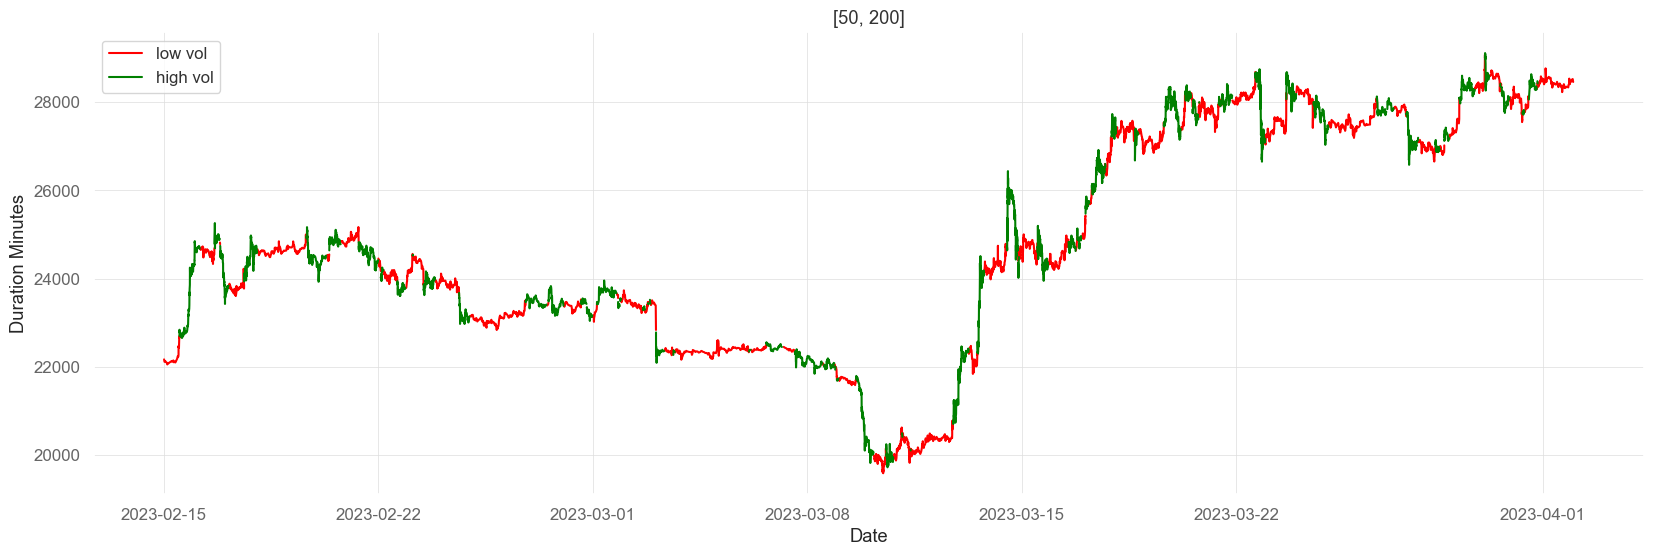

In [25]:
#lets graph it to see if it looks good

start = '2023-02-15'
end = '2023-4-01'

plot_sample = db_slice.loc[start:end].copy()
# plot_sample['cross'] = plot_sample['cross'].shift(1)


plot_sample['high vol'] = np.where(plot_sample['vol'] == 'high vol', plot_sample['Close'], None)
plot_sample['low vol'] = np.where(plot_sample['vol'] == 'low vol', plot_sample['Close'], None)

# Plot the Close, SMA, and EMA
plt.figure(figsize=(20, 6))
plt.plot(plot_sample.index, plot_sample['low vol'], label='low vol', color = 'red')
plt.plot(plot_sample.index, plot_sample['high vol'], label='high vol', color = 'green')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Duration Minutes')
plt.title(f'[{ema_window}, {sma_window}]')
plt.legend()

# Display the plot
plt.show()

In [42]:
#Chart looks good. If we use the close time as the index this is accurate as at the candles close we know its duration and therefore can calucate the ema and smas.
#If we use Open Time there is a bias of 1 candle (a couple of mins)

#Now we need to get the vol back onto a minute dataframe

minute_candles = df_btc.loc['2022-01-01':].copy().reset_index()
vol_model = db_slice.copy().reset_index()
df1 = vol_model.copy()
df2 = minute_candles.copy()



#I am shifting the vol column because at the end of the candle we know the volatility. and now I am going to look at each candle in the minute data and see which dollar bar candle it fits into 
# and set the volatility based off that row's vol. However this would have a a look ahead bias if I didn't shift
df1['vol'] = df1['vol'].shift(1)
# print(df1.head(300).to_markdown())
df2 = df2.rename(columns={'datetime': 'Open Time'})
# df2 = df2[df2['Open Time'] < '2022-02-01']

# Convert all timestamps to UTC or make them tz-naive
df2['Open Time'] = df2['Open Time'].dt.tz_convert(None)
df1['Open Time'] = df1['Open Time'].dt.tz_convert(None)
df1['Close Time'] = df1['Close Time'].dt.tz_convert(None)

# Re-do the merge_asof if needed
merged_df = pd.merge_asof(df2, df1, left_on='Open Time', right_on='Open Time', direction='backward')

# Create the dictionary for the Close Time lookup
close_time_dict = dict(zip(df1['Open Time'], df1['Close Time']))

# Filter out incorrect matches using the Close Time
merged_df['vol'] = merged_df.apply(lambda row: row['vol'] if row['Open Time'] <= close_time_dict.get(row['Open Time'], pd.Timestamp.max) else None, axis=1)

# Set 'Open Time' as the index if required
merged_df.set_index('Open Time', inplace=True)


In [51]:
#now lets take a look and see if this works 
#looks good, need to clean it up a little
# merged_df = merged_df[['Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x', 'vol']]
merged_df = merged_df.rename(columns={'Open_x' : 'Open', 'High_x':'High', 'Low_x': 'Low', 'Close_x': 'Close', 'Volume_x':'Volume'})
merged_df = merged_df.dropna()

print(merged_df)

                         Open      High       Low     Close   Volume       vol
Open Time                                                                     
2022-01-03 08:53:00  46939.61  46948.12  46931.66  46948.12   27.513   low vol
2022-01-03 08:54:00  46948.11  46962.17  46942.03  46958.20   45.487   low vol
2022-01-03 08:55:00  46961.01  46967.28  46954.63  46954.64   24.046   low vol
2022-01-03 08:56:00  46954.64  46963.43  46950.00  46962.54   31.567   low vol
2022-01-03 08:57:00  46962.53  46992.00  46955.00  46987.33   47.728   low vol
...                       ...       ...       ...       ...      ...       ...
2023-12-11 20:36:00  40663.80  40672.50  40623.40  40665.60  194.250  high vol
2023-12-11 20:37:00  40665.70  40728.80  40655.70  40715.90  302.775  high vol
2023-12-11 20:38:00  40716.10  40716.10  40688.60  40702.10  260.268  high vol
2023-12-11 20:39:00  40702.00  40742.10  40682.80  40682.80  291.341  high vol
2023-12-11 20:40:00  40682.80  40691.40  40646.80  4

In [57]:
"""
Now that we have generated the volatility model, only a couple more steps until we build the strategy
The strategy uses a sort of ATR to determine tp and doubling down moments. So lets make that 

Thought process: 
These trades are going to be on for potentially an hour to a couple hours. 
So we look at the last 12 hours to see how much the market has been moving. 
I chunked it up into 6 2 hour periods and I look at the atr of each of these candles (high - low / open)
Then we average those 6 periods to get a number we will use in the strategy later
"""

vol_model = merged_df.copy()
df = vol_model.loc['2022-01-01':].copy()

two_hour_candle = df.copy().resample(f"2H").agg(
        {
            "Open": "first",
            "High": "max",
            "Low": "min",
            "Close": "last",
        }
    )

two_hour_candle['atr'] = (two_hour_candle['High'] - two_hour_candle['Low']) / two_hour_candle['Open']

#shift the atr because we only know the atr at the end of the candle
two_hour_candle['atr'] = two_hour_candle['atr'].shift(1)

two_hour_candle['rolling_atr'] = two_hour_candle['atr'].rolling(window=6).mean()

mapping = df.index.to_series().dt.floor('2H')

# Map the rolling_range from the two-hour candle DataFrame to the minute candle DataFrame
df['two_hour_rolling_atr'] = mapping.map(two_hour_candle['rolling_atr'])

df= df.dropna()


In [86]:
#now that we have the atr on the same dataframe as the volatility we are ready to make the strategy. 

#need an sma
def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

class PMvol(Strategy):
    
    LEVERAGE_STATS_2x = {0:0, 1:.5, 2: 1.5, 3:2}
    LEVERAGE_STATS_1x = {0:0, 1:.25, 2: .75, 3:1}
    TRADE_SIZES = {0: .25, 1: .666, 2: .99, 3: 0, 4:0}

    LEVERAGE_STATS = LEVERAGE_STATS_2x

    MAX_TRADES = 3
   
    TP= .003
    SL = -.05
    MAX_TP = .008
    ADD_THRESH = -.006
    
    n1 = 20*60*4
    n2 = 50*60*4
    
    def _atr(self):
        return self.data.two_hour_rolling_atr
    
    def _vol(self):
        return self.data.vol
    
    def init(self):
        super().init()
        self.atr = self.I(self._atr)
        self.vol = self.I(self._vol)

        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        super().next()

        if not self.position:
            # print(f'{self.data.index[-1]} : {self.vol[-1]}')

            if self.vol[-1] == -1:
                if self.sma1 > self.sma2:
                    # print('Bought Long')
                    self.buy(size=self.TRADE_SIZES[0])
                else:
                    # print('Bought Short')
                    self.sell(size=self.TRADE_SIZES[0])

        if self.position:
            
            if self.vol[-1] == 1:
                self.position.close()

            if self.position.pl_pct * self.LEVERAGE_STATS[len(self.trades)] < self.SL:
                self.position.close()

            
            elif self.position.is_long and self.sma1[-1] < self.sma2[-1]:
                # print(f'Cross {round(self.position.pl_pct, 4)}')
                self.position.close()
            elif self.position.is_short and self.sma1[-1] > self.sma2[-1]:
                # print(f'Cross {round(self.position.pl_pct, 4)}')
                self.position.close()
            
            
            elif self.trades[-1].pl_pct < -(self.atr[-1]) and len(self.trades) < self.MAX_TRADES:
                # print(f"added {self.atr[-1]}")
                if self.position.is_long:
                    self.buy(size=self.TRADE_SIZES[len(self.trades)])
                else:
                    self.sell(size=self.TRADE_SIZES[len(self.trades)])

            # elif self.trades[-1].pl_pct < self.ADD_THRESH and len(self.trades) == self.MAX_TRADES:
            #     print(f'new stop loss {self.position.pl_pct*self.LEVERAGE_STATS[len(self.trades)]}')
            #     self.position.close()

            elif self.position.pl_pct > (self.atr[-1] /2):
                # print(f"Tp {self.atr[-1] /2}")
                self.position.close()
    
        


Win Rate: 75.98522167487684
Average Losing Trade: -0.00914087632692609
Average Winning Trade: 0.0036094611310045818
Best Trade: 0.03667718694136868
Worst Trade: -0.06314787550557399
Trades worse than 4.0% : 26
Total Return 346.0363204599996%
Max Drawdown: 28.775340492414177%

RowCount = 1:
Positive Trades: 1435
Negative Trades: 328
Win Rate: 81.40%
Average Losing Trade: -0.002390
Average Winning Trade: 0.002728
Best Trade: 0.015083
Worst Trade: -0.012605
Trades worse than 5.0%: 0
Expected Value of Trade: 0.0017755024686136182

RowCount = 2:
Positive Trades: 352
Negative Trades: 136
Win Rate: 72.13%
Average Losing Trade: -0.011581
Average Winning Trade: 0.006807
Best Trade: 0.036677
Worst Trade: -0.058554
Trades worse than 5.0%: 3
Expected Value of Trade: 0.0016822204671543047

RowCount = 3:
Positive Trades: 64
Negative Trades: 121
Win Rate: 34.59%
Average Losing Trade: -0.024699
Average Winning Trade: 0.005799
Best Trade: 0.012910
Worst Trade: -0.063148
Trades worse than 5.0%: 5
Expect

c:\blockforce\quant-lab\research\volatility\../..\helpers\data_helpers.py:235: RuntimeWarning: invalid value encountered in longlong_scalars
  positive_rowcount / (positive_rowcount + negative_rowcount)


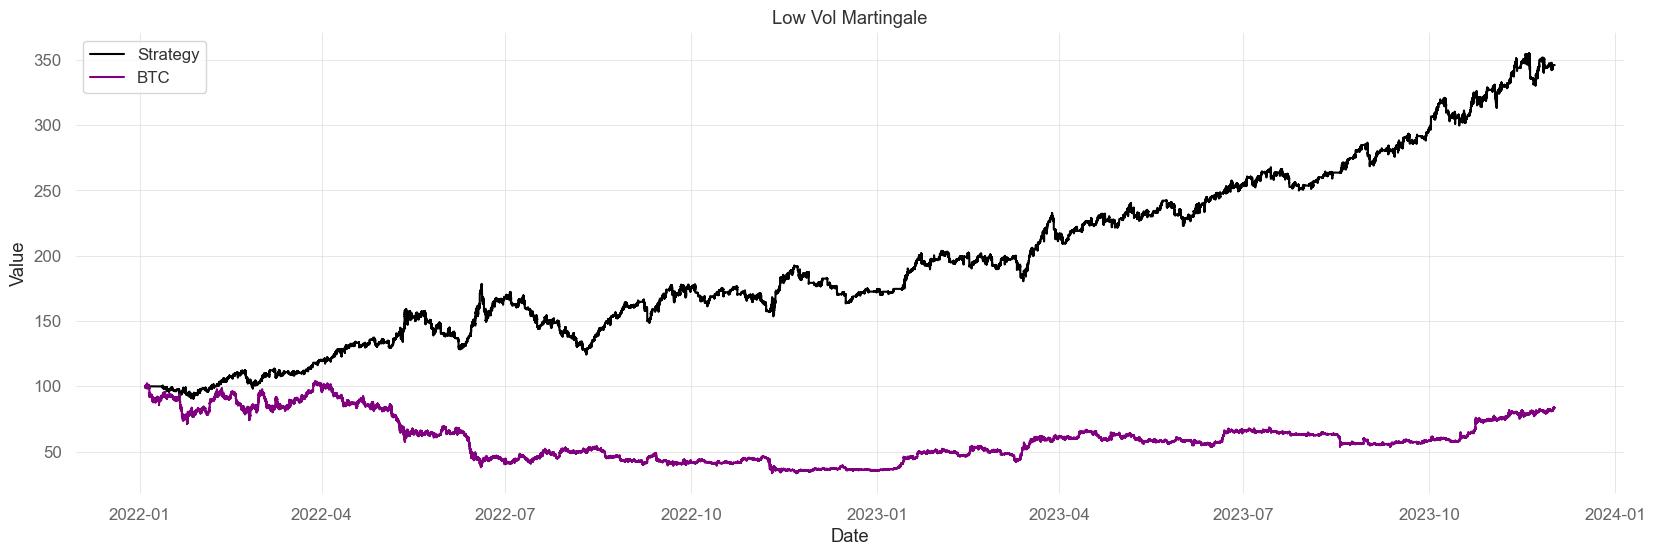

In [87]:

bt_start = '2022-01-01'
bt_end = '2023-12-01'


bt_data = df.copy()

bt_data.loc[bt_data['vol'] == 'low vol', 'vol'] = -1
bt_data.loc[bt_data['vol'] == 'high vol', 'vol'] = 1


# print(bt_data.loc[bt_start:bt_end])
bt = Backtest(
    bt_data.loc[bt_start:bt_end],
    PMvol,
    cash=100_000_000,
    trade_on_close=False,
    commission=0.0000,
    exclusive_orders=False,
    margin=.5,  # Set this to 0.5 for 2x leverage, 0.25 for 4x leverage, 0.125 for 8x leverage, etc.
)

stat = bt.run()
print(stat)

cleaned_trades = data_helpers.calc_acc_stats(stat['_trades'], 100_000_000)

eq_curve = stat['_equity_curve'] / 1000000
daily_df = eq_curve.resample('D').last()

plot_sample = eq_curve.loc[bt_start:bt_end].copy()
plot_sample_btc = bt_data.loc[bt_start:bt_end].copy()

plot_sample_btc['Normalized Price'] = plot_sample_btc['Close'] / plot_sample_btc['Close'].iloc[0] * 100

plt.figure(figsize=(20, 6))
plt.plot(plot_sample.index, plot_sample['Equity'], label='Strategy', color = 'black')
plt.plot(plot_sample_btc.index, plot_sample_btc['Normalized Price'], label='BTC', color = 'purple')
# Set labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Low Vol Martingale')
plt.legend()


In [ ]:
"""
3% stop loss is good for no leverage 
5% stop loss is good for 2x leverage 
3% stop loss is also good for 2x leverage but you lose some returns and only make up a little drawdown
"""

In [85]:
shorts = cleaned_trades[cleaned_trades['FirstEntrySize'] < 0]
longs = cleaned_trades[cleaned_trades['FirstEntrySize'] > 0]

shorts_total = shorts['adj pnl'].sum()
longs_total = longs['adj pnl'].sum()

print(f'The total Return for Shorts: {shorts_total}')
print(f'The total Return for Longs: {longs_total}')

The total Return for Shorts: 0.37881578251513626
The total Return for Longs: 0.8314211431256984
